# Modeling Chicago Bike Usage with Prophet

<div style="border: 2px solid #2980b9; border-radius: 10px; padding: 20px; background-color: #f0f8ff;">

<h3><strong>Introduction</strong></h3>

<p>In recent years, bike-sharing programs have become essential components of urban mobility systems offering a sustainable and affordable mode of transportation. Chicago’s <strong>Divvy</strong> bike-share system is serves both residents and tourists across the city. Its data can be found on their site in open access.</p>

<p>Understanding how and when people use shared bikes is critical for effective <em>planning, operations, and infrastructure development</em>. This project combines <strong>exploratory data analysis (EDA)</strong> and <strong>time series forecasting</strong> to uncover user behavior patterns and anticipate future demand.</p>

<p><strong>Research Questions</strong></p>

<p><strong>Descriptive (EDA) Questions:</strong></p>
<ol>
  <li>How do riding behaviors differ between <em>members</em> and <em>casual users</em>?</li>
  <li>What are the <em>seasonal and weekly patterns</em> in bike usage?</li>
  <li>How do <em>weather conditions</em> and <em>holidays</em> influence ride counts?</li>
</ol>

<p>These questions are addressed through <strong>exploratory data analysis</strong>, visualization, and statistical testing to determine whether observed patterns are statistically significant.</p>

<p><strong>Predictive (Modeling) Questions:</strong></p>
<ol start="4">
  <li>Can we accurately <em>forecast daily bike rides</em> for members and casual users?</li>
  <li>Which factors (e.g., <em>weather, holidays</em>) help improve forecast accuracy?</li>
  <li>How well do different forecasting models (e.g., <em>SARIMA vs. Prophet</em>) perform in predicting future demand?</li>
</ol>

<p>These questions are answered by implementing and evaluating time series models, enabling <em>data-driven planning</em> for future ride volumes.</p>

<p><strong>Data Sources</strong></p>
<ul>
  <li><strong>Divvy Trip Data:</strong> Publicly available trip records from <a href="https://divvybikes.com/system-data">Divvy Bikes</a>, including ride timestamps, user type, and duration.</li>
  <li><strong>Weather Data:</strong> Hourly and daily weather metrics from <a href="https://www.visualcrossing.com/resources/documentation/weather-data/getting-started-with-weather-data-services/">Visual Crossing</a>, including temperature, snow depth, visibility, and precipitation.</li>
  <li><strong>Holidays Dataset:</strong> A manually created list of U.S. holidays that may affect bike usage.</li>
</ul>

<p><strong>Use of the Research</strong></p>
<p>This analysis can support:</p>
<ul>
  <li><em>Operational optimization</em> (e.g., bike rebalancing, staffing)</li>
  <li><em>Infrastructure planning</em> (e.g., station placement, expansion)</li>
  <li><em>Marketing strategy</em> (e.g., targeting casual users with potential for conversion)</li>
  <li><em>Weather- and event-aware forecasting</em> for proactive decision-making</li>
</ul>

</div>


# EDA

Loading libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from prophet import Prophet
from pmdarima import auto_arima
import scipy.stats as stats  
from scipy.stats import skew, kurtosis, ttest_1samp, ttest_ind

Reading Divvy data. The data was pulled from the Divvy bike share website and covers the period from January 1, 2023 to November 30, 2024

In [7]:
# Replace 'your_file.csv' with the actual path to your CSV file
combined_df = pd.read_csv(r'D:\Elena\Datasets\Chicago bike rides\combined_df.csv')
combined_df.head()

,ride_id,started_at,member_casual
0,F96D5A74A3E41399,2023-01-21,member
1,13CB7EB698CEDB88,2023-01-10,member
2,BD88A2E670661CE5,2023-01-02,casual
3,C90792D034FED968,2023-01-22,member
4,3397017529188E8A,2023-01-12,member


Some basic information about the dataset: number of rows and columns, names of the columns and data types.

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11402073 entries, 0 to 11402072
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ride_id        object
 1   started_at     object
 2   member_casual  object
dtypes: object(3)
memory usage: 261.0+ MB


The dataset does not contain NaN values

In [11]:
combined_df.isna().sum()

ride_id          0
started_at       0
member_casual    0
dtype: int64

The next step is to remove duplicate rows

In [13]:
# Check for duplicates based on specific columns
duplicate_rows = combined_df[combined_df.duplicated(subset=['ride_id'])]

# Print duplicate rows
print(duplicate_rows)

# Count duplicates
print(f"Number of duplicates based on ['ds', 'y']: {duplicate_rows.shape[0]}")

                  ride_id  started_at member_casual
7417487  3B5CE4D8B3EE6ED8  2024-05-31        casual
7417511  60B4DDFF369931B2  2024-05-31        casual
7417536  1D8856396862BE62  2024-05-31        casual
7418795  B1B9E66D2E7C383D  2024-05-31        casual
7422651  9FF6FFB668739B47  2024-05-31        member
...                   ...         ...           ...
8117175  2C2CD7C3DCBC3C39  2024-05-31        casual
8119346  532780A49B9089CD  2024-05-31        casual
8120377  9B43F7CB54CFB914  2024-05-31        member
8121700  7817F106775A6E24  2024-05-31        casual
8122724  A5CEDF5535693FFB  2024-05-31        casual

[211 rows x 3 columns]
Number of duplicates based on ['ds', 'y']: 211


In [14]:
# Remove duplicates based on specific columns
combined_df = combined_df.drop_duplicates(subset=['ride_id'])

There are two customer types in the dataset: members and casual users.
To understand usage patterns, it makes sense to compare the number of daily bike rides for each category.
We’ll use visualizations to explore and compare these ride trends over time.

In [16]:
# Convert `started_at` to datetime
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])

# Group by date and `member_casual`
grouped_data = combined_df.groupby([combined_df['started_at'].dt.date, 'member_casual']).size().reset_index(name='count')

# Pivot the data for easier comparison
pivoted_data = grouped_data.pivot(index='started_at', columns='member_casual', values='count').fillna(0)

print(pivoted_data.head())

member_casual  casual  member
started_at                   
2023-01-01       1991    3144
2023-01-02       1593    3914
2023-01-03       1145    3982
2023-01-04       1431    5830
2023-01-05       1262    5310


The line plots below reveal a clear seasonal trend:both members and casual users take more bike rides during the summer months and fewer during winter.
Additionally, members consistently take more rides than casual users throughout the year.

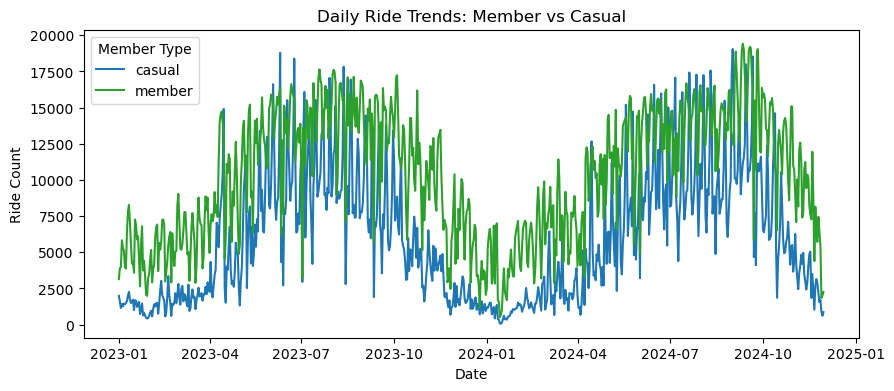

In [18]:
# Plot trends for `member` and `casual`
# Define a custom color palette (for two bars: member & casual)
colors = ['#1f77b4', '#2ca02c']  # Blue for members, green for casual users
pivoted_data.plot(figsize=(10, 4), color=colors)
plt.title('Daily Ride Trends: Member vs Casual')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend(title='Member Type')
plt.show()

We also created a bar plot to show the number of bike rides by day of the week.
The pattern is clear:

- Members take more rides on weekdays,

- while casual users ride more on weekends.

This likely reflects different usage behaviors:
Members may be Chicago residents using bikes for commuting,
whereas casual users are likely tourists or locals riding for leisure.

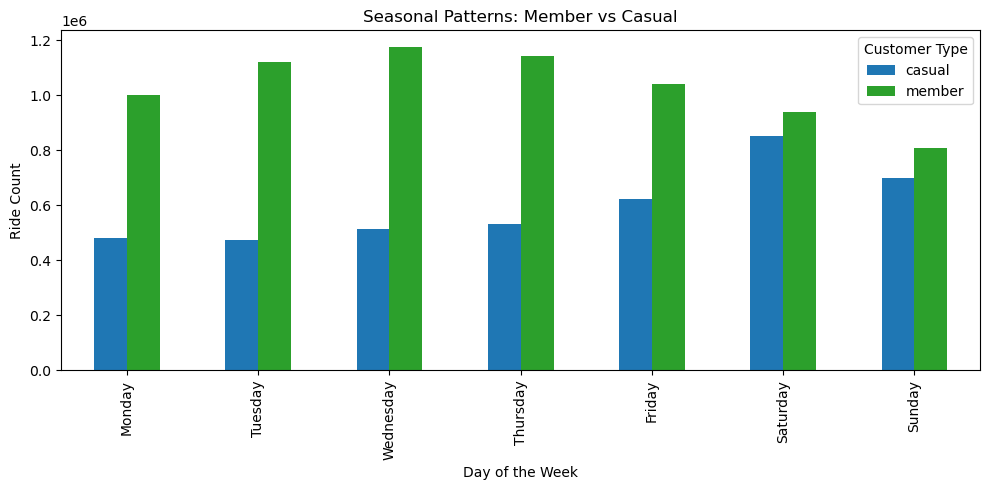

In [20]:
# Add day of the week
combined_df['day_of_week'] = combined_df['started_at'].dt.day_name()

# Group by `member_casual` and `day_of_week`
seasonal_data = combined_df.groupby(['day_of_week', 'member_casual']).size().unstack()

# Plot seasonal patterns
seasonal_data = seasonal_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Define a custom color palette (for two bars: member & casual)
colors = ['#1f77b4', '#2ca02c']  # Blue for members, green for casual users

# Plot with custom colors
seasonal_data.plot(kind='bar', figsize=(10, 5), color=colors)
plt.title('Seasonal Patterns: Member vs Casual')
plt.xlabel('Day of the Week')
plt.ylabel('Ride Count')
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

What can we say looking at the descriptive statistics? The dataset contains 700 daily observations for both member and casual riders.
Here are a few key insights:

- Members consistently take more rides than casual users.

- Average daily rides: 10,328 for members vs. 5,960 for casual users.

- Median daily rides: 10,956 (members) vs. 5,117 (casual), confirming this gap.

- Casual usage is more variable.

- Standard deviation is higher relative to the mean for casual users (4,429 vs. 5,960) than for members (4,393 vs. 10,328).

- Casual rides range from 61 to 19,044, indicating occasional spikes (e.g., weekends, events).

- Members have a higher and more stable ride volume.

- Minimum member rides per day is still 505, far above the minimum for casuals.

These patterns suggest:

- Members use bikes more consistently, likely for commuting.

- Casual users ride less frequently but show high variability, possibly due to seasonal tourism, weather, or weekend activities.

In [22]:
print(pivoted_data['member'].describe())
print(pivoted_data['casual'].describe())

count      700.000000
mean     10327.904286
std       4393.371590
min        505.000000
25%       6654.500000
50%      10955.500000
75%      14192.750000
max      19414.000000
Name: member, dtype: float64
count      700.000000
mean      5960.470000
std       4429.494439
min         61.000000
25%       1927.250000
50%       5116.500000
75%       8978.750000
max      19044.000000
Name: casual, dtype: float64


We can add statistical confidence to the observed patterns in our exploratory analysis. We perform an independent two-sample t-test to compare the average number of daily rides between member and casual users. Although descriptive statistics show that members take more rides on average, the t-test tells us whether this difference is statistically significant — not just due to random variation. We use equal_var=False (Welch’s t-test) because the variances of the two groups are likely unequal.

Interpretation:

- If the p-value < 0.05, we conclude that the difference in mean ride counts is statistically significant.

- If the p-value ≥ 0.05, we conclude that the difference could be due to random chance.

In [24]:
# Daily ride counts for `member` and `casual`
member_rides = pivoted_data['member']
casual_rides = pivoted_data['casual']

# Perform t-test
t_stat, p_value = ttest_ind(member_rides, casual_rides, equal_var=False)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference in average rides between 'member' and 'casual' is statistically significant.")
else:
    print("No significant difference in average rides between 'member' and 'casual'.")

T-Statistic: 18.521539078122476, P-Value: 1.1586336268620312e-68
The difference in average rides between 'member' and 'casual' is statistically significant.


To analyze ride patterns by customer type, we split the dataset into two subsets: members and casual users.

In [26]:
# Split into two subsets and make explicit copies
member = combined_df[combined_df['member_casual'] == 'member'].copy()
casual = combined_df[combined_df['member_casual'] == 'casual'].copy()

# Rename columns for clarity
member.rename(columns={'started_at': 'ds', 'rides': 'member_rides'}, inplace=True)
casual.rename(columns={'started_at': 'ds', 'rides': 'casual_rides'}, inplace=True)

# Print the results
print("Member Weekly Data:")
print(member)

print("\nCasual Weekly Data:")
print(casual)

Member Weekly Data:
                   ride_id         ds member_casual day_of_week
0         F96D5A74A3E41399 2023-01-21        member    Saturday
1         13CB7EB698CEDB88 2023-01-10        member     Tuesday
3         C90792D034FED968 2023-01-22        member      Sunday
4         3397017529188E8A 2023-01-12        member    Thursday
5         58E68156DAE3E311 2023-01-31        member     Tuesday
...                    ...        ...           ...         ...
11402068  6F18BF26B4BFBA75 2024-11-21        member    Thursday
11402069  4FC0C36143D89998 2024-11-09        member    Saturday
11402070  8E244ADE5B1653D4 2024-11-23        member    Saturday
11402071  65F9D9F5648FAC03 2024-11-05        member     Tuesday
11402072  5C84C9E88DB67D3B 2024-11-15        member      Friday

[7229533 rows x 4 columns]

Casual Weekly Data:
                   ride_id         ds member_casual day_of_week
2         BD88A2E670661CE5 2023-01-02        casual      Monday
13        9DC70E5EE9D6A93F 2023-01-

We have two time series for which we plan to build forecasting models.
Before fitting any models (such as ARIMA, SARIMA, or Prophet), it's important to first examine the statistical properties of the data.
This ensures that the chosen model is appropriate for the data’s characteristics, such as stationarity, seasonality, and autocorrelation.

## Member EDA

In [29]:
# Group by the date and count the number of rides
member_daily = member.groupby('ds').size().reset_index(name='y')

# Rename the columns for clarity
#rides_per_day.rename(columns={'started_at': 'date'}, inplace=True)
member_daily.head()

,ds,y
0,2023-01-01,3144
1,2023-01-02,3914
2,2023-01-03,3982
3,2023-01-04,5830
4,2023-01-05,5310


First, we build a histogram and qq-plots: 
- The histogram of daily rides for members shows a bimodal distribution, suggesting the presence of two distinct peaks. This may reflect seasonal variation.

- The Q-Q plot further confirms non-normality. Deviations from the diagonal line in the lower left and upper right corners indicate potential outliers or skewness.

These results suggest that the data does not follow a normal distribution

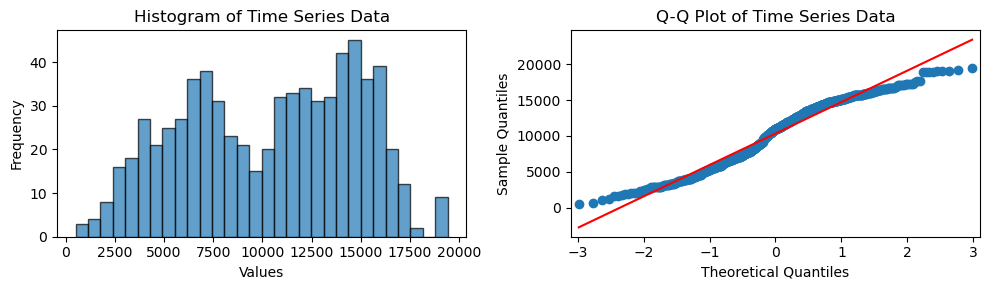

In [31]:
# Ensure 'ds' is parsed as datetime if not already
member_daily['ds'] = pd.to_datetime(member_daily['ds'])

# Sort by date to maintain proper time order
member_daily.sort_values('ds', inplace=True)

# Extract the 'y' column for analysis
time_series = member_daily['y']  # Replace 'y' with the appropriate column name if different

# Plot Histogram and Q-Q Plot side by side
plt.figure(figsize=(10, 3))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(time_series, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Time Series Data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
qqplot(time_series, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Time Series Data')

# Display the plots
plt.tight_layout()
plt.show()

**Ljung-Box Test (Lag = 10)**
   
Purpose: To test whether the time series residuals are independently distributed (i.e., no autocorrelation).

- Null hypothesis (H₀): The data are independently distributed (no autocorrelation).

- Alternative hypothesis (H₁): The data are not independently distributed (there is autocorrelation).

Result:

Test statistic: 3642.90

p-value: 0.0

Interpretation:
Since the p-value is less than 0.05, we reject the null hypothesis. The time series exhibits significant autocorrelation, suggesting time-dependent structure in the data.

**Augmented Dickey-Fuller (ADF) Test**

Purpose: To test for a unit root and assess stationarity of the time series.

- Null hypothesis (H₀): The time series has a unit root (i.e., it is non-stationary).

- Alternative hypothesis (H₁): The time series is stationary.

Result:

ADF statistic: -1.33

p-value: 0.614

Interpretation:
The p-value is greater than 0.05, so we fail to reject the null hypothesis. The data is non-stationary, which is problematic for many time series models and requires transformation (e.g., differencing).

**One-Sample t-Test**

Purpose: To test whether the mean daily ride count for members is significantly different from zero.

- Null hypothesis (H₀): The mean = 0

- Alternative hypothesis (H₁): The mean ≠ 0

Result:

t-statistic: 62.20

p-value: 4.05e-287 

Interpretation:
The p-value is far below 0.05, so we reject the null hypothesis. The average daily ride count for members is significantly different from zero, as expected.

**Skewness and Kurtosis**

Purpose: To assess the shape of the distribution.

Skewness: -0.16 We see slight left skew, indicating that lower values occur slightly more often than expected under normality.

Kurtosis: 1.90 Platykurtic distribution, suggesting lighter tails and fewer extreme outliers.

**Overall Conclusion**:

- The series is non-stationary and has significant autocorrelation, which violates the assumptions of many time series models.

- It has a significantly positive mean, with a slightly skewed and flatter-than-normal distribution.

Next steps: Apply differencing, possibly log or seasonal adjustments, and account for autocorrelation before fitting models such as ARIMA or Prophet.


Ljung-Box Test Results:
        lb_stat  lb_pvalue
10  3642.895543        0.0

ADF Test Results:
ADF Statistic: -1.332279862915694
p-value: 0.6142779368248849
Critical Values: {'1%': -3.4400174432106305, '5%': -2.8658060125001295, '10%': -2.569041777564251}

One-Sample t-Test Results:
t-statistic: 62.19611918468165, p-value: 4.049162890449912e-287

Skewness and Kurtosis:
Skewness: -0.16238712050794907
Kurtosis: 1.9006778261455914


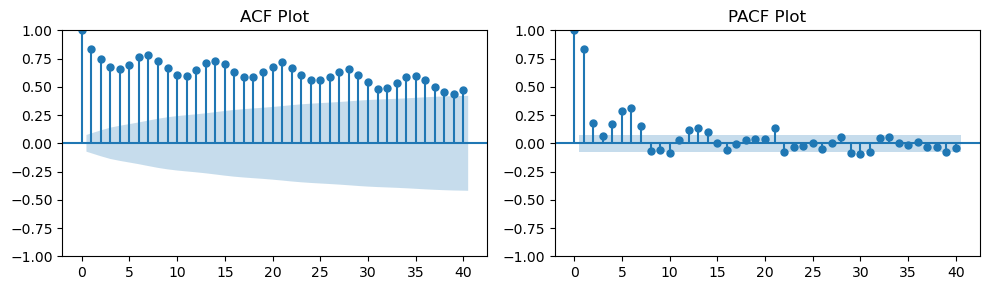

In [33]:
# Ensure 'ds' is parsed as datetime if not already
member_daily['ds'] = pd.to_datetime(member_daily['ds'])

# Sort by date to maintain proper time order
member_daily.sort_values('ds', inplace=True)

# Extract the 'y' column for analysis
time_series = member_daily['y']  # Replace 'y' with the appropriate column name if different

# 1. Ljung-Box Test
ljung_box_results = acorr_ljungbox(time_series, lags=[10], return_df=True)  # Adjust lags if needed
print("Ljung-Box Test Results:")
print(ljung_box_results)

# 2. Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(time_series)
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# 3. One-Sample t-Test
t_stat, p_value = ttest_1samp(time_series, popmean=0)
print("\nOne-Sample t-Test Results:")
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# 4. Skewness and Kurtosis
series_skewness = skew(time_series)
series_kurtosis = kurtosis(time_series, fisher=False)  # Pearson definition
print("\nSkewness and Kurtosis:")
print(f"Skewness: {series_skewness}")
print(f"Kurtosis: {series_kurtosis}")

# 5. ACF and PACF Plots
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Plot ACF
plot_acf(time_series, lags=40, ax=axes[0])
axes[0].set_title("ACF Plot")

# Plot PACF
plot_pacf(time_series, lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

Further we apply STL decomposition (Seasonal-Trend decomposition using Loess) to the member_daily time series. The goal is to break the series down into three interpretable components:trend, seasonal, and residual. The decomposition plot clearly shows two key patterns in the time series:

- Trend: there is a clear upward trend in daily rides, indicating a consistent increase in bike usage among members over time. This may reflect growing adoption of the bike share system or increased rider engagement.

- Seasonality. The seasonal component displays a recurring yearly pattern: more rides in summer, fewer rides in winter, which aligns with expected weather-related behavior.

These findings confirm that the time series exhibits non-stationarity and strong annual seasonality. These patterns can be effectively modeled using tools like Prophet or seasonal ARIMA.

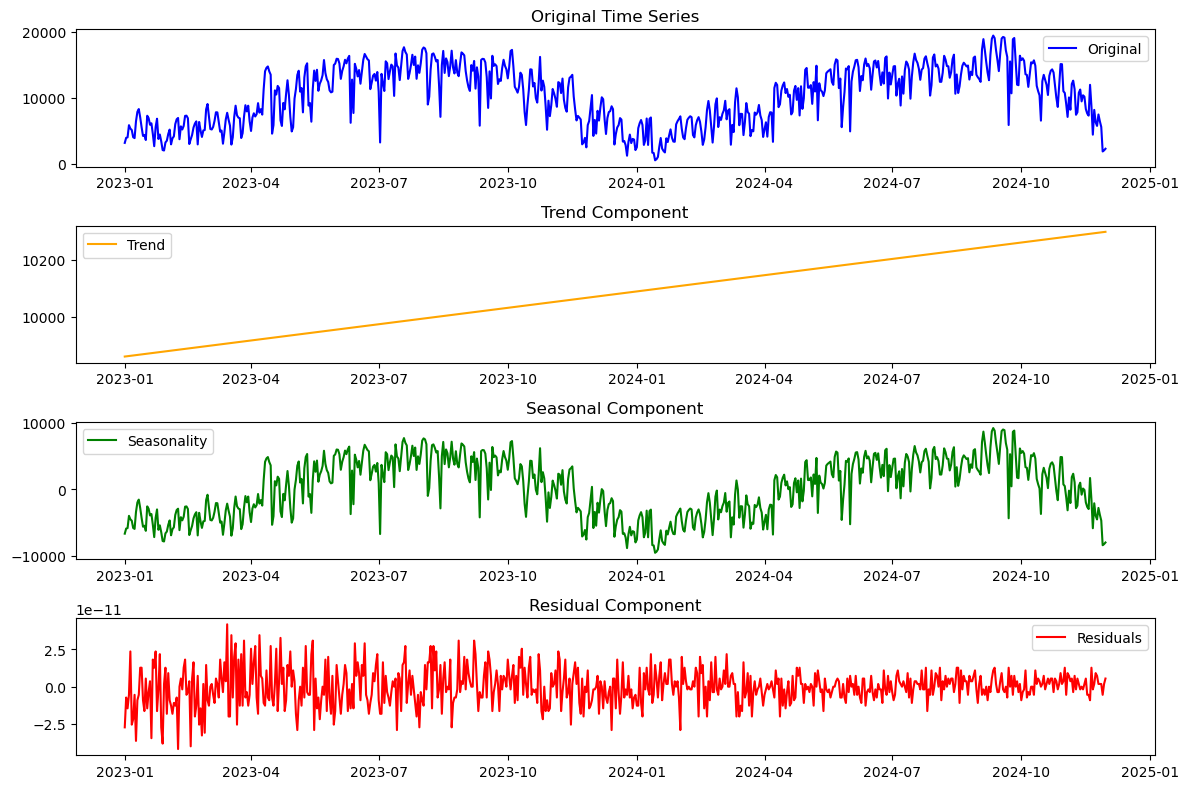

In [35]:
# Ensure 'ds' is parsed as datetime and sorted
member_daily['ds'] = pd.to_datetime(member_daily['ds'])
member_daily.sort_values('ds', inplace=True)

# Extract the 'y' column for decomposition
time_series = member_daily['y']

# Perform STL decomposition
stl = STL(time_series, period=365)  # Adjust `period` based on seasonality (e.g., 365 for yearly data)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposition results
plt.figure(figsize=(12, 8))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(member_daily['ds'], time_series, label='Original', color='blue')
plt.title('Original Time Series')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(member_daily['ds'], trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(member_daily['ds'], seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.legend()

# Residuals
plt.subplot(4, 1, 4)
plt.plot(member_daily['ds'], residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

Summary of the results:

- The time series is non-stationary, as confirmed by the ADF test.

- strong autocorrelation (Ljung-Box test) and distinct annual seasonality (STL decomposition).

- The data has a bimodal, slightly skewed distribution and a strong positive trend.

- STL decomposition reveals that both trend and seasonality are key components of this time series.

Given these characteristics, the most appropriate models are:

- Prophet, which is designed to handle non-stationary time series with strong trend and seasonal components. It models automatically daily, weekly, yearly seasonality, and changepoints in trend. The bonus is that this model does not require differencing or stationarity and incorporates easily additional factors like holidays, which may affect bike usage.

- Seasonal ARIMA (SARIMA) It is slightly more complex to configure than Prophet, especially with non-linear trends or multiple seasonalities

## Casual EDA

We will perform the same tests on casual time series.

In [39]:
# Group by the date and count the number of rides
casual_daily = casual.groupby('ds').size().reset_index(name='y')

# Rename the columns for clarity
#rides_per_day.rename(columns={'started_at': 'date'}, inplace=True)

# Display the resulting DataFrame
print(casual_daily)

            ds     y
0   2023-01-01  1991
1   2023-01-02  1593
2   2023-01-03  1145
3   2023-01-04  1431
4   2023-01-05  1262
..         ...   ...
695 2024-11-26  1554
696 2024-11-27  1715
697 2024-11-28   898
698 2024-11-29   609
699 2024-11-30   860

[700 rows x 2 columns]


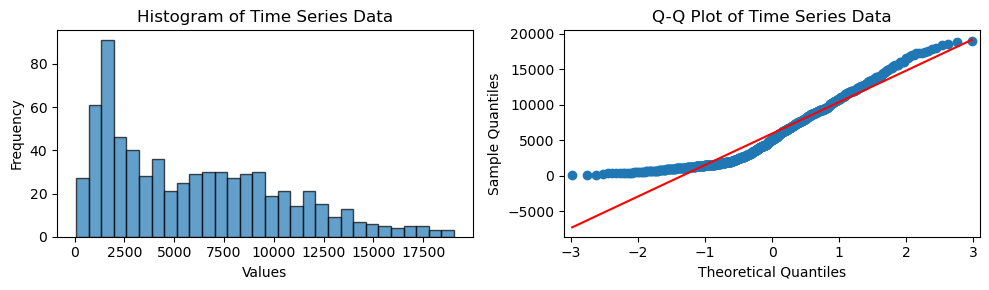

In [40]:
# Ensure 'ds' is parsed as datetime if not already
casual_daily['ds'] = pd.to_datetime(casual_daily['ds'])

# Sort by date to maintain proper time order
casual_daily.sort_values('ds', inplace=True)

# Extract the 'y' column for analysis
time_series = casual_daily['y']  # Replace 'y' with the appropriate column name if different

# Plot Histogram and Q-Q Plot side by side
plt.figure(figsize=(10, 3))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(time_series, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Time Series Data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
qqplot(time_series, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Time Series Data')

# Display the plots
plt.tight_layout()
plt.show()

The histogram is skewed to the right, the qq-plot deviates from the normal distribution in the lower left corner.

Ljung-Box Test Results:
        lb_stat  lb_pvalue
10  3271.097535        0.0

ADF Test Results:
ADF Statistic: -1.3258437239260605
p-value: 0.6172674198069913
Critical Values: {'1%': -3.4400174432106305, '5%': -2.8658060125001295, '10%': -2.569041777564251}

One-Sample t-Test Results:
t-statistic: 35.602079499636744, p-value: 3.7384563430965134e-159

Skewness and Kurtosis:
Skewness: 0.714113120354445
Kurtosis: 2.6523234045030253


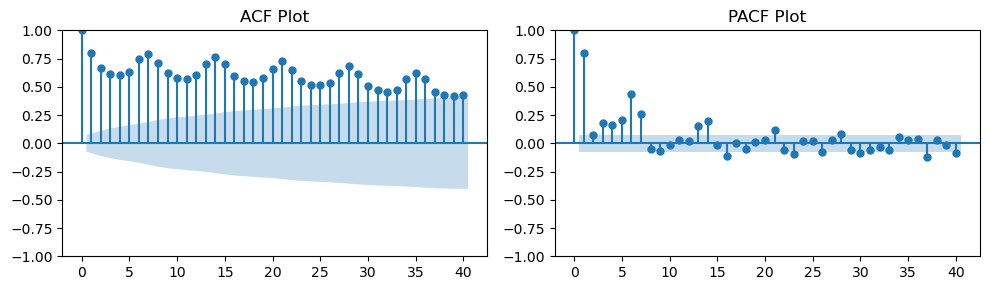

In [42]:
# Ensure 'ds' is parsed as datetime if not already
casual_daily['ds'] = pd.to_datetime(casual_daily['ds'])

# Sort by date to maintain proper time order
casual_daily.sort_values('ds', inplace=True)

# Extract the 'y' column for analysis
time_series = casual_daily['y']  # Replace 'y' with the appropriate column name if different

# 1. Ljung-Box Test
ljung_box_results = acorr_ljungbox(time_series, lags=[10], return_df=True)  # Adjust lags if needed
print("Ljung-Box Test Results:")
print(ljung_box_results)

# 2. Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(time_series)
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# 3. One-Sample t-Test
t_stat, p_value = ttest_1samp(time_series, popmean=0)
print("\nOne-Sample t-Test Results:")
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# 4. Skewness and Kurtosis
series_skewness = skew(time_series)
series_kurtosis = kurtosis(time_series, fisher=False)  # Pearson definition
print("\nSkewness and Kurtosis:")
print(f"Skewness: {series_skewness}")
print(f"Kurtosis: {series_kurtosis}")

# 5. ACF and PACF Plots
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Plot ACF
plot_acf(time_series, lags=40, ax=axes[0])
axes[0].set_title("ACF Plot")

# Plot PACF
plot_pacf(time_series, lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

**Ljung-Box Test (Lag = 10)**

Null hypothesis (H₀): No autocorrelation (the series is white noise)

Result: test statistic: 3271.10, p-value: 0.0

Interpretation:
Since the p-value is less than 0.05, we reject the null hypothesis. The time series shows significant autocorrelation, meaning past values influence future values.

**Augmented Dickey-Fuller (ADF) Test**

Null hypothesis (H₀): The series is non-stationary (has a unit root)

Result: ADF statistic: -1.33, p-value: 0.617

Interpretation:
The p-value is much greater than 0.05 → we fail to reject the null hypothesis. The series is non-stationary and may need differencing before using ARIMA-type models.

**One-Sample t-Test**

Null hypothesis (H₀): The mean ride count = 0

Result: t-statistic: 35.60, p-value: ~0

Interpretation:
The mean daily ride count is significantly different from zero, as expectedConfirms there is a strong upward signal in the data.

**Skewness and Kurtosis**

- Skewness: 0.71, it indicates a moderate right skew, meaning higher ride counts (e.g., peak weekends, summer spikes) are more frequent than extremely low ones.

- Kurtosis: 2.65, slightly platykurtic, indicating lighter tails and fewer extreme outliers than in a normal distribution.

Conclusion:
The casual rides time series is non-stationary, autocorrelated, and moderately right-skewed. Like the member series, it requires models that can capture trend and seasonality. These characteristics are well-suited for Prophet or SARIMA.

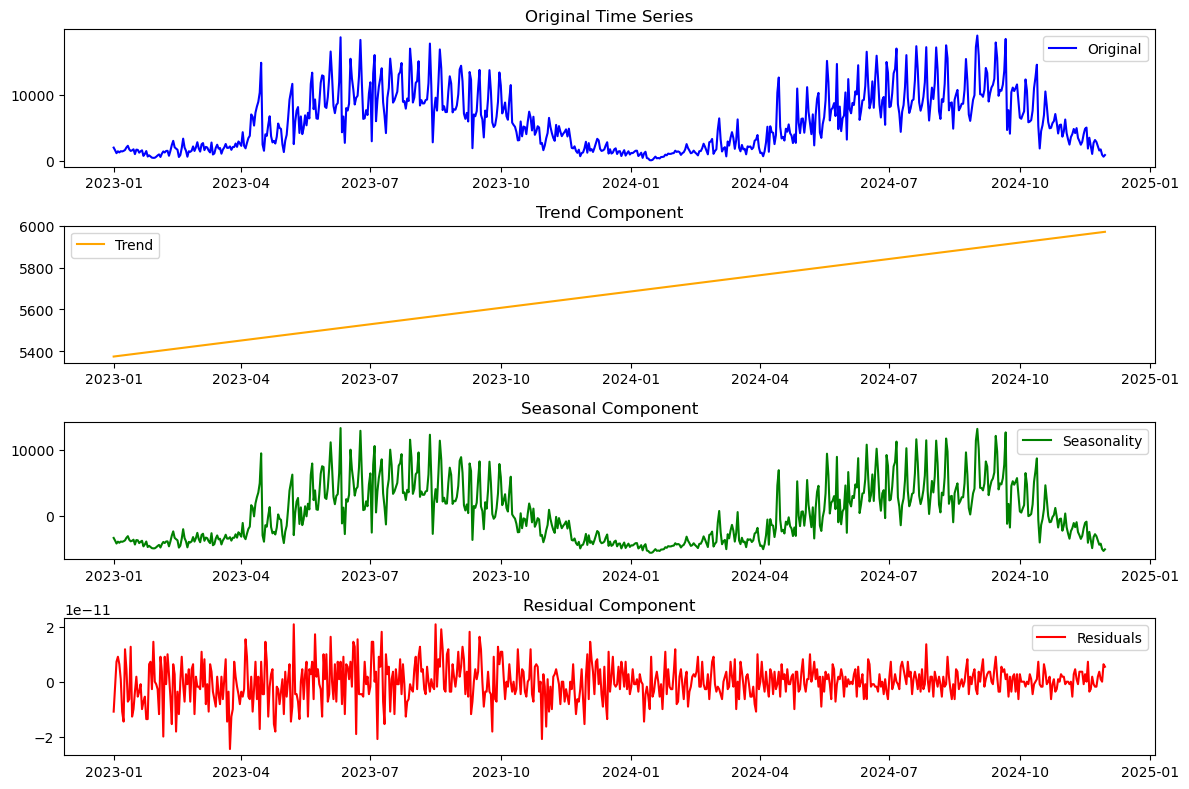

In [44]:
# Ensure 'ds' is parsed as datetime and sorted
casual_daily['ds'] = pd.to_datetime(casual_daily['ds'])
casual_daily.sort_values('ds', inplace=True)

# Extract the 'y' column for decomposition
time_series = casual_daily['y']

# Perform STL decomposition
stl = STL(time_series, period=365)  # Adjust `period` based on seasonality (e.g., 365 for yearly data)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposition results
plt.figure(figsize=(12, 8))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(casual_daily['ds'], time_series, label='Original', color='blue')
plt.title('Original Time Series')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(casual_daily['ds'], trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(casual_daily['ds'], seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.legend()

# Residuals
plt.subplot(4, 1, 4)
plt.plot(casual_daily['ds'], residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

STL decomposition plot for casual users looks similar to that of the member time series:

- Trend: there is a clear upward trend in daily rides, indicating a consistent increase in bike usage among members over time. This may reflect growing adoption of the bike share system or increased rider engagement.

- Seasonality. The seasonal component displays a recurring yearly pattern: more rides in summer, fewer rides in winter, which aligns with expected weather-related behavior.

These findings confirm that the time series exhibits non-stationarity and strong annual seasonality. 

Given the non-stationarity, strong annual seasonality, and clear trend, the casual time series will be best modeled using Prophet. This model is
ideal for capturing both trend and seasonality. It automatically handles non-stationary data and requires minimal manual transformation. Seasonal ARIMA (SARIMA) is the second best choice.

## Holidays

It is likely that holidays influence bike ride patterns, as people may ride more for leisure. For this reason, we created a holiday dataset to capture the dates of relevant public holidays. Prophet allows us to include holiday effects directly in the model, enabling it to learn unique patterns around holidays. This is especially useful for modeling casual users, who may ride more on holidays due to leisure activities. Members, on the contrary, may ride less if commuting is reduced on holidays.

In [49]:
holidays = pd.read_csv("holidays.csv")
holidays.head()

,ds,holiday,lower_window,upper_window
0,1/2/2023,New Year,-1,1
1,1/16/2023,Martin Luther King,-1,1
2,2/20/2023,Presidents Day,-1,1
3,5/29/2023,Memorial Day,-1,1
4,6/19/2023,Juneteenth,-1,1


In [50]:
# Convert Date column to datetime format (year-month-day)
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%m/%d/%Y')
print(holidays.dtypes)
# Verify conversion
holidays.head()

ds              datetime64[ns]
holiday                 object
lower_window             int64
upper_window             int64
dtype: object


,ds,holiday,lower_window,upper_window
0,2023-01-02,New Year,-1,1
1,2023-01-16,Martin Luther King,-1,1
2,2023-02-20,Presidents Day,-1,1
3,2023-05-29,Memorial Day,-1,1
4,2023-06-19,Juneteenth,-1,1


## Weather

Weather probably is a key external factor in bike ride behavior. We suppose that including it in the model can significantly improve forecast accuracy.
Casual users are probably highly sensitive to weather and ride mostly in good conditions, especially on weekends or holidays. Members will also show reduced usage in bad weather.

In [53]:
# Read the first CSV file
file1 = r'D:\Elena\Datasets\Chicago bike rides\chicago_2023.csv'  # Replace with your first CSV file name
df1 = pd.read_csv(file1)

# Read the second CSV file
file2 = r'D:\Elena\Datasets\Chicago bike rides\chicago_2024.csv'  # Replace with your second CSV file name
df2 = pd.read_csv(file2)

# Concatenate the two DataFrames
weather = pd.concat([df1, df2], ignore_index=True)

# Display the concatenated DataFrame
weather.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,chicago,2023-01-01,44.2,37.1,41.1,41.3,32.0,38.1,38.1,89.1,...,2.0,1,NaN,2023-01-01T07:18:22,2023-01-01T16:30:02,0.32,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
1,chicago,2023-01-02,43.1,31.9,38.1,39.6,31.5,34.7,35.3,90.0,...,2.2,1,NaN,2023-01-02T07:18:26,2023-01-02T16:30:54,0.36,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,F7086,..."


In [54]:
weather.isna().sum()

name                  0
datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          430
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk          102
sunrise               0
sunset                0
moonphase             0
conditions            0
description           0
icon                  0
stations              0
dtype: int64

In [55]:
# Convert 'datetime' to include only the date (year, month, day)
weather['datetime'] = pd.to_datetime(weather['datetime']).dt.normalize()

# Filter data up to 2023-11-30
weather_trimmed = weather.loc[weather['datetime'] <= pd.Timestamp('2024-11-30')]

# Check the result
print(weather_trimmed['datetime'].min().date(), weather_trimmed['datetime'].max().date())

2023-01-01 2024-11-30


In [56]:
# Drop columns with NaN values
weather_cleaned = weather_trimmed.dropna(axis=1)
# Select only numeric columns for PCA
weather_cleaned = weather_cleaned.select_dtypes(include=[np.number])

# Check the cleaned dataset
print(weather_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 699
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           700 non-null    float64
 1   tempmin           700 non-null    float64
 2   temp              700 non-null    float64
 3   feelslikemax      700 non-null    float64
 4   feelslikemin      700 non-null    float64
 5   feelslike         700 non-null    float64
 6   dew               700 non-null    float64
 7   humidity          700 non-null    float64
 8   precip            700 non-null    float64
 9   precipprob        700 non-null    int64  
 10  precipcover       700 non-null    float64
 11  snow              700 non-null    float64
 12  snowdepth         700 non-null    float64
 13  windgust          700 non-null    float64
 14  windspeed         700 non-null    float64
 15  winddir           700 non-null    float64
 16  sealevelpressure  700 non-null    float64
 17  cl

# Models for Member Time Series

## Baseline SARIMA without Covariates

We decided to apply an incremental model development, starting from simple to complex. Our first model is a SARIMA model fitted using only the historical time series values. The purpose of including this model is twofold:

- To serve as a benchmark for evaluating the added predictive value of external covariates.

- To validate that the time series structure contains sufficient autocorrelation and seasonality to support basic forecasting in the absence of external data.

ARIMA model usually requires differencing non-stationary data. However, we will use auto-arima, which automatically determines the appropriate parameters:

d = number of non-seasonal differences (to remove trend)

D = number of seasonal differences (to remove seasonal trend)

It tries different combinations of (p, d, q)(P, D, Q) using model selection criteria like AIC/BIC

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12387.461, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12285.014, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12250.192, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12385.476, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=12299.681, Time=0.51 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=12231.336, Time=2.37 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.97 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=12361.007, Time=0.46 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12174.368, Time=5.18 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12181.850, Time=2.87 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=12289.9

D:\Jupyter\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


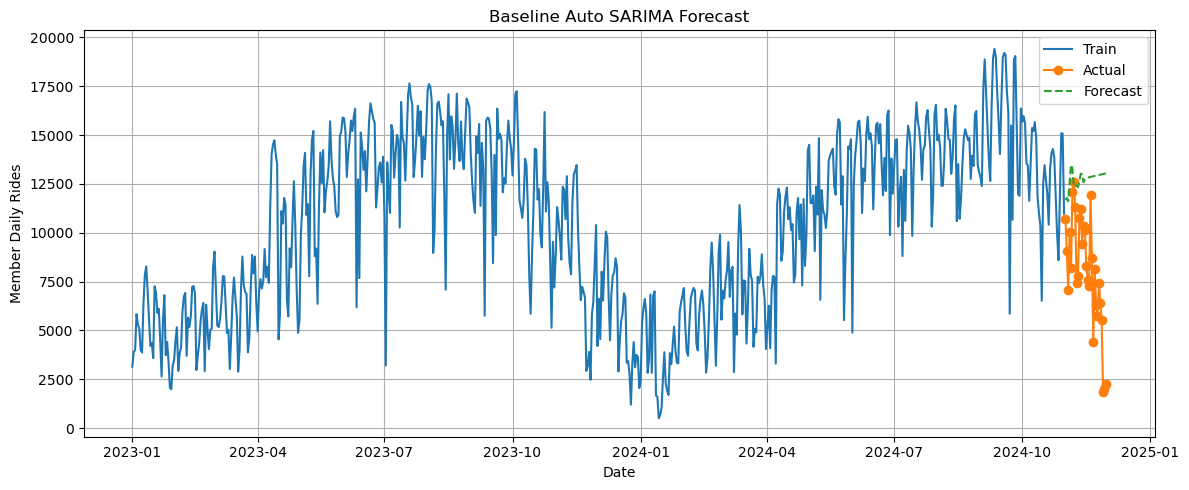

In [60]:
# Load and prepare data
member_daily['ds'] = pd.to_datetime(member_daily['ds'])
member_daily.set_index('ds', inplace=True)
y = member_daily['y']

# Train-test split (e.g., last 30 days as test)
train = y[:-30]
test = y[-30:]

# Fit baseline auto_arima model
model = auto_arima(
    train,
    seasonal=True,
    m=7,  # Weekly seasonality
    stepwise=True,
    suppress_warnings=True,
    trace=True  # Optional: shows tested models
)

# Forecast
n_periods = len(test)
forecast = model.predict(n_periods=n_periods)
forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"\nBaseline Auto SARIMA Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
plt.title('Baseline Auto SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Member Daily Rides')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model plays an important role in understanding the core dynamics of the system before adding explanatory variables. 

We used auto_arima() to fit a seasonal ARIMA model to the member daily ride data. The algorithm automatically determines the appropriate levels of differencing and seasonality. The best model selected is ARIMA(1,1,1)(0,0,2). This model captures:
  - Non-stationarity with one level of differencing (`d=1`)
  - Weekly seasonality (`m=7`) with two seasonal MA terms (`Q=2`)
  
The model fits the overall trend and seasonality but struggles with accuracy on the test set. Forecasts may be improved by including exogenous variables like weather or holidays. Alternative models like Prophet are worth trying.


## Member Time Series Forecasting: Prophet with Covariates 

This time, we will experiment with the Prophet model, which is well-suited for time series with trend, seasonality, and holiday effects. Prophet is designed to handle non-stationary data and can automatically model weekly and yearly seasonality. It also allows for the inclusion of exogenous variables, such as weather and holidays data. Including these external factors can help improve forecast accuracy by accounting for sudden changes or non-regular patterns in bike usage.

We will first retain only the numerical features from the weather dataset and merge them with the member ride time series based on the date. To identify which weather conditions are most relevant, we will compute correlation coefficients between each weather variable and the number of daily rides. Variables with a strong positive or negative correlation with ride volume will be used as covariates.

In [65]:
# keep ds as a column
member_daily = member_daily.reset_index()  # if needed

# Convert 'ds' in member_daily to datetime
member_daily['ds'] = pd.to_datetime(member_daily['ds'], format='%Y-%m-%d')

# Convert 'datetime' in weather to datetime (ensure it's a copy, not a view)
weather = weather[['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',  'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility']]
weather['datetime'] = pd.to_datetime(weather['datetime'], format='%Y-%m-%d')

# Merge the datasets
merged_data = pd.merge(member_daily, weather, left_on='ds', right_on='datetime')

# Drop the duplicate 'datetime' column
merged_data = merged_data.drop(columns=['datetime'])

# Check the merged dataset
merged_data.head(3)

,ds,y,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility
0,2023-01-01,3144,44.2,37.1,41.1,41.3,32.0,38.1,38.1,89.1,...,100,12.50,0.0,0.0,15.4,8.7,228.4,1014.0,93.7,5.0
1,2023-01-02,3914,43.1,31.9,38.1,39.6,31.5,34.7,35.3,90.0,...,0,0.00,0.0,0.0,19.7,12.0,49.5,1017.2,86.0,4.6
2,2023-01-03,3982,46.6,39.4,42.9,45.2,32.6,39.4,41.7,95.4,...,100,54.17,0.0,0.0,23.0,13.5,36.5,1004.3,99.6,1.9


In [66]:
"""correlation_matrix = merged_data.corr(method='spearman')
#print(correlation_matrix['y'].sort_values(ascending=False))
# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()"""

'correlation_matrix = merged_data.corr(method=\'spearman\')\n#print(correlation_matrix[\'y\'].sort_values(ascending=False))\n# Plot heatmap\nplt.figure(figsize=(12, 12))\nsns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")\nplt.title("Correlation Matrix")\nplt.show()'

We will compute Spearman correlation and plot a correlation matrix heatmap. Spearman correlation is used when data is not normally distributed, or when relationships are non-linear but monotonic. More robust to outliers.

In [68]:
correlation_matrix = merged_data.corr(method='spearman')
spearman_corr = merged_data.corr(method='spearman')
target_corr = spearman_corr['y'].sort_values(ascending=False)  # Assuming 'y' is your target
print(target_corr)

y                   1.000000
tempmax             0.843721
feelslikemax        0.838530
temp                0.837690
feelslike           0.836860
feelslikemin        0.798298
tempmin             0.791253
dew                 0.717201
visibility          0.386710
ds                  0.257744
sealevelpressure   -0.077110
winddir            -0.203488
windgust           -0.208029
windspeed          -0.226215
precipprob         -0.230315
precip             -0.244904
precipcover        -0.290853
snow               -0.333751
humidity           -0.378567
cloudcover         -0.450386
snowdepth          -0.453680
Name: y, dtype: float64


In [69]:
# Filter features with Spearman correlation to target |corr| >= 0.3
selected_features = target_corr[abs(target_corr) >= 0.3].drop('y').index.tolist()
print("Selected features:", selected_features)

Selected features: ['tempmax', 'feelslikemax', 'temp', 'feelslike', 'feelslikemin', 'tempmin', 'dew', 'visibility', 'snow', 'humidity', 'cloudcover', 'snowdepth']


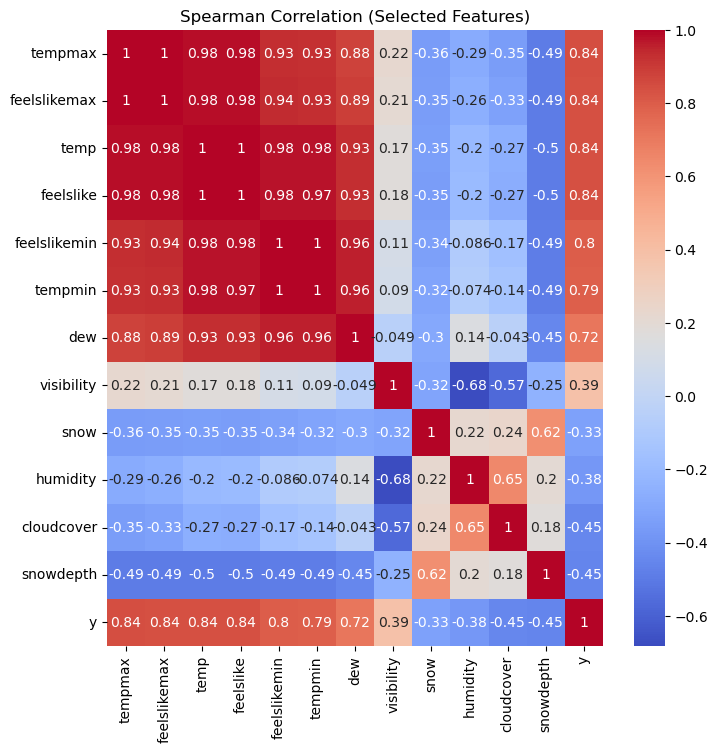

In [70]:
plt.figure(figsize=(8, 8))
sns.heatmap(spearman_corr.loc[selected_features + ['y'], selected_features + ['y']], annot=True, cmap="coolwarm")
plt.title("Spearman Correlation (Selected Features)")
plt.show()

In [71]:
# Drop any rows with missing values
data_for_vif = merged_data[selected_features].dropna()

# Add constant column for intercept
X = add_constant(data_for_vif)

# Create a DataFrame to hold VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort and display
print(vif_data.sort_values(by="VIF", ascending=False))

         Feature          VIF
0          const  3456.647563
3           temp  1492.647798
4      feelslike   811.985656
7            dew   449.015868
1        tempmax   324.555111
6        tempmin   289.540758
5   feelslikemin   264.996633
2   feelslikemax   244.952320
10      humidity    61.330701
8     visibility     2.318024
11    cloudcover     1.914577
12     snowdepth     1.695656
9           snow     1.314979


To avoid multicollinearity, we will use Variance Inflation Factor (VIF):
VIF > 10: high multicollinearity (in this case the feature should be dropped or combined)

VIF 5–10: moderate multicollinearity (consider addressing)

VIF < 5: low multicollinearity (usually okay)

In [73]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

features = selected_features.copy()
data = merged_data[features].dropna()

while True:
    X = add_constant(data[features])
    vif_df = calculate_vif(X)
    max_vif = vif_df.loc[vif_df["Feature"] != 'const', "VIF"].max()
    
    if max_vif <= 10:
        break
    
    # Drop the feature with the highest VIF (excluding 'const')
    drop_feature = vif_df.sort_values(by="VIF", ascending=False).iloc[1]["Feature"]
    print(f"Dropping '{drop_feature}' with VIF = {max_vif:.2f}")
    features.remove(drop_feature)

print("Final selected features with acceptable VIFs:")
print(features)

Dropping 'temp' with VIF = 1492.65
Dropping 'feelslike' with VIF = 380.15
Dropping 'dew' with VIF = 189.55
Dropping 'tempmin' with VIF = 108.92
Dropping 'tempmax' with VIF = 99.00
Dropping 'feelslikemax' with VIF = 12.21
Final selected features with acceptable VIFs:
['feelslikemin', 'visibility', 'snow', 'humidity', 'cloudcover', 'snowdepth']


While Spearman correlation and VIF were used to identify a statistically sound subset of features with low multicollinearity, a manually selected set of features — which included feelslike and precipcover — outperformed the automated selection in predictive accuracy. This suggests that the removed features, despite their multicollinearity, carried significant predictive power, potentially due to nonlinear interactions or domain relevance. Therefore, in contexts where prediction is prioritized over interpretability, retaining certain collinear but important features may be beneficial.

In [75]:
member_df = merged_data[['ds', 'y', 'feelslike', 'visibility', 'precipcover', 'cloudcover', 'snowdepth']] #'ds', 'y', 'feelslike', 'cloudcover', 'snowdepth', 'visibility', 'precipcover'
member_df.head()

,ds,y,feelslike,visibility,precipcover,cloudcover,snowdepth
0,2023-01-01,3144,38.1,5.0,12.50,93.7,0.0
1,2023-01-02,3914,34.7,4.6,0.00,86.0,0.0
2,2023-01-03,3982,39.4,1.9,54.17,99.6,0.0
3,2023-01-04,5830,30.8,8.5,4.17,89.6,0.0
4,2023-01-05,5310,25.4,7.0,8.33,99.7,0.2


In [76]:
# create test dataset, remove last 12 months
train = member_df.drop(member_df.index[-30:])
test = member_df.tail(30)
train.tail()

,ds,y,feelslike,visibility,precipcover,cloudcover,snowdepth
665,2024-10-27,8595,48.7,9.9,0.0,29.6,0.0
666,2024-10-28,11721,54.9,9.9,0.0,69.3,0.0
667,2024-10-29,15092,74.0,9.9,0.0,83.4,0.0
668,2024-10-30,15074,73.6,9.9,0.0,76.5,0.0
669,2024-10-31,10977,59.4,9.9,12.5,92.5,0.0


We configure a custom Prophet model to capture the key patterns and external factors influencing member daily rides: 

- holidays=holidays, this parameter incorporates a predefined list of holidays we created, allowing the model to capture spikes or drops in ride counts around these dates.

- holidays_prior_scale=3: Controls the strength (flexibility) of holiday effects. 

- changepoint_prior_scale=0.1: Determines how flexible the model is with trend changes. A lower value makes the trend smoother whereas a higher value allows for more abrupt shifts.

- seasonality_prior_scale=5: Adjusts flexibility of the seasonal components. Higher values allow stronger seasonal variation.

- yearly_seasonality=True: Enables Prophet’s built-in yearly seasonality, useful for capturing summer/winter ride trends.

- weekly_seasonality=False: Disables Prophet’s default weekly pattern, so we can add a custom weekly seasonality instead.

- we add a custom weekly seasonality component with a 7-day cycle with fourier_order=5. It controls the complexity (flexibility) of the seasonal pattern where higher values allow more intricate weekly fluctuations.

In [78]:
# Initialize the model
model_cov = Prophet(
    holidays=holidays,
    holidays_prior_scale=3,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=5,
    yearly_seasonality=True,  # Keep yearly seasonality
    weekly_seasonality=False  # Disable built-in weekly seasonality
)

# Add custom weekly seasonality
model_cov.add_seasonality(name='weekly', period=7, fourier_order=5)

# Add covariates as regressors
model_cov.add_regressor('feelslike') 
model_cov.add_regressor('cloudcover')
model_cov.add_regressor('snowdepth')
model_cov.add_regressor('visibility')
model_cov.add_regressor('precipcover')

# Reset index so 'ds' becomes a column
train = train.reset_index()

# Fit the model
model_cov.fit(train)  # Ensure 'train' contains ds, y, and regressor columns

12:17:53 - cmdstanpy - INFO - Chain [1] start processing
12:17:54 - cmdstanpy - INFO - Chain [1] done processing


            ds         yhat   yhat_lower    yhat_upper
695 2024-11-26  9049.752753  7739.749350  10233.332153
696 2024-11-27  6371.954212  5060.706460   7563.929723
697 2024-11-28  1057.336902  -156.786071   2327.504588
698 2024-11-29  2092.062234   869.171416   3397.579280
699 2024-11-30  5334.117913  4111.610121   6536.695852


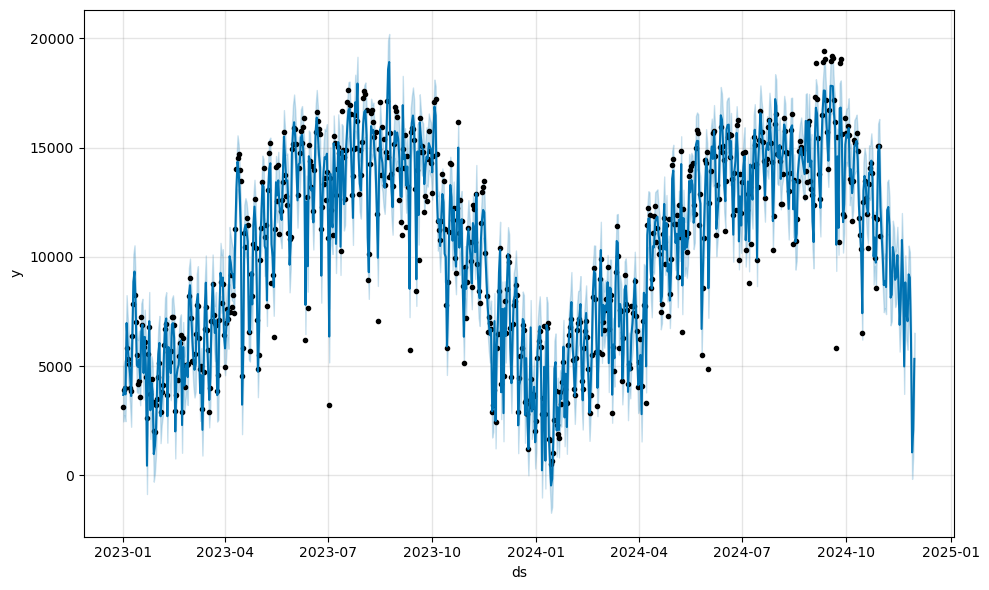

In [79]:
# Create a future DataFrame
future = model_cov.make_future_dataframe(periods=30)

# Add covariate data to the future DataFrame
future = future.merge(weather, left_on='ds', right_on='datetime', how='left')

# Ensure only necessary columns are kept
future = future[['ds', 'feelslike', 'cloudcover', 'snowdepth', 'visibility', 'precipcover', 'snow']]
# Predict
forecast = model_cov.predict(future)

# Display forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot forecast
_ = model_cov.plot(forecast)

MAE: 865.889
RMSE: 1111.398
MAPE: 15.72%


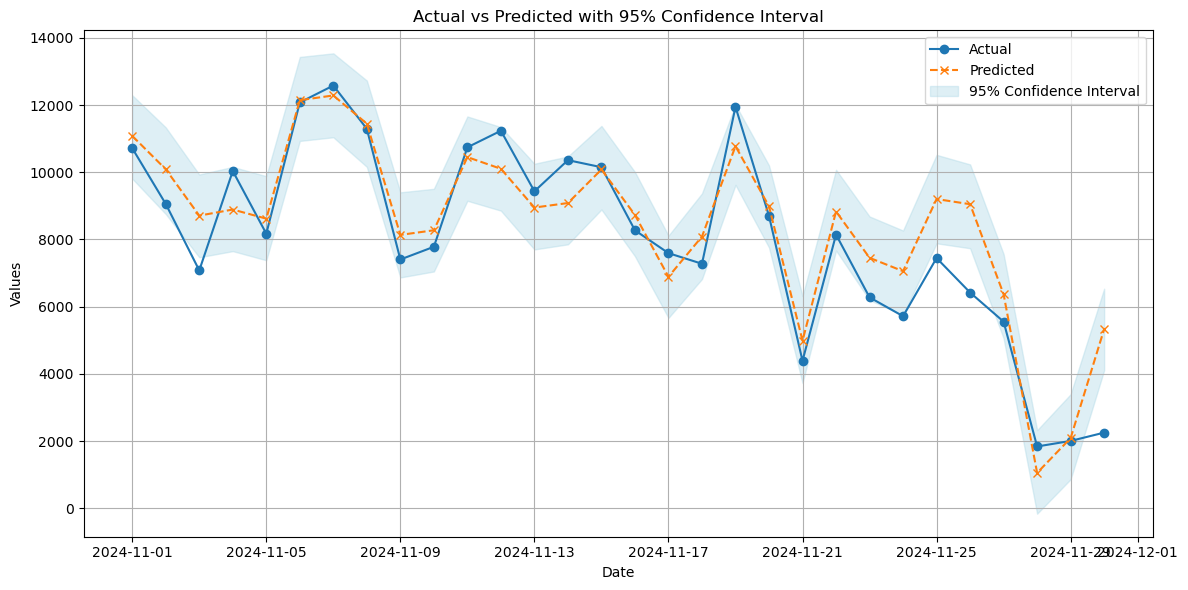

In [80]:
# Merge test data with full forecast results
evaluation_df = test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

# Extract actual and predicted values
y_true = evaluation_df['y'].values
y_pred = evaluation_df['yhat'].values

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(evaluation_df['ds'], y_true, label='Actual', marker='o', linestyle='-')
plt.plot(evaluation_df['ds'], y_pred, label='Predicted', marker='x', linestyle='--')

# Confidence interval
plt.fill_between(evaluation_df['ds'],
                 evaluation_df['yhat_lower'],
                 evaluation_df['yhat_upper'],
                 color='lightblue', alpha=0.4, label='95% Confidence Interval')

# Formatting
plt.title('Actual vs Predicted with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
relative_mean = mae/member_daily['y'].mean()
relative_mean

0.08383972996263803

Out-of-sample statistics:

- MAE (Mean Absolute Error): 865.89 This means that, on average, the model’s predictions are off by about 866 rides per day. 

- RMSE (Root Mean Squared Error): 1111.40 RMSE is similar to MAE, but penalizes larger errors more heavily. In this case, on average, predictions are about 1,111 rides off, also measured in rides.

- MAPE (Mean Absolute Percentage Error): 15.72% It shows the average percentage error relative to the actual values. In this case, MAPE of 15.72% means that, on average, predictions are about 15.72% off from the actual daily ride counts. Generally, MAPE under 20% is considered quite accurate.

- Relative Mean Error: 0.08 (or 8%) The value of 0.08 means the model slightly overestimates on average by 8%, but it's still well within acceptable bounds.

Prophet model is accurate (low MAE and RMSE) and well-calibrated (low relative bias) This suggests that adding weather and holiday effects to Prophet significantly improved model performance.

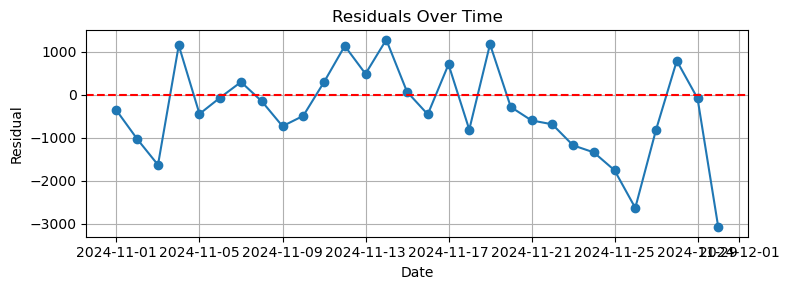

In [83]:
# Residuals = Actual - Predicted
evaluation_df['residual'] = evaluation_df['y'] - evaluation_df['yhat']
plt.figure(figsize=(8, 3))
plt.plot(evaluation_df['ds'], evaluation_df['residual'], label='Residuals', marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

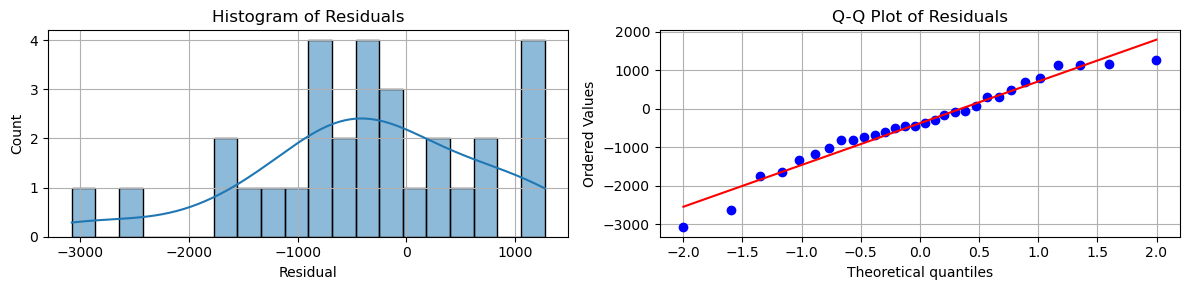

In [84]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Histogram with KDE
sns.histplot(evaluation_df['residual'], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Histogram of Residuals")
axes[0].set_xlabel("Residual")
axes[0].grid(True)

# Q-Q plot
stats.probplot(evaluation_df['residual'], dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [85]:
# One-sample t-test: is the mean of residuals = 0?
t_stat, p_value = ttest_1samp(evaluation_df['residual'], popmean=0)

print(f"One-Sample t-Test Results:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

One-Sample t-Test Results:
t-statistic: -1.936, p-value: 0.063


A one-sample t-test for zero-mean residuals returned a p-value of 0.063, which is slightly above the 0.05 threshold. This suggests that the residuals are approximately centered around zero, indicating the absence of significant bias in the model's predictions.

Now it is time for diagnostics on residuals: Ljung-Box test, ACF/PACF plots, and t-tests. A good model should not only produce accurate forecasts but also meet certain statistical assumptions. Evaluating the residuals helps us check whether the model is truly capturing the underlying structure of the time series.

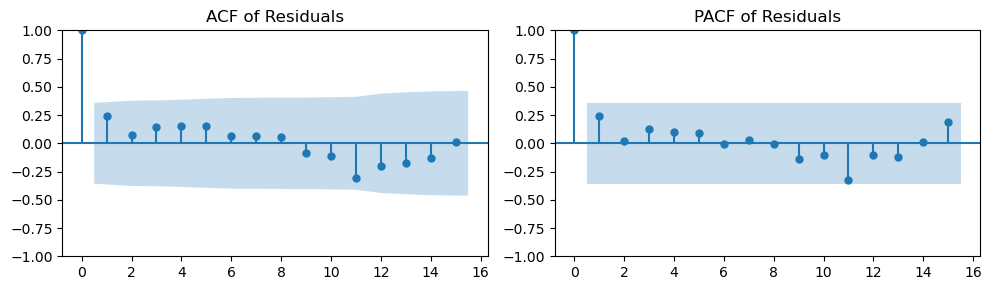

In [88]:
# Adjust the number of lags to be < length of residuals
n_obs = len(evaluation_df['residual'])
lags = min(15, n_obs - 1)  # safe choice for short series

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# ACF plot
plot_acf(evaluation_df['residual'], lags=lags, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(evaluation_df['residual'], lags=lags, ax=axes[1], method='ywm')
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()

In [89]:
ljung_box = acorr_ljungbox(evaluation_df['residual'], lags=[10], return_df=True)
print("Ljung-Box test:")
print(ljung_box)

Ljung-Box test:
     lb_stat  lb_pvalue
10  5.974545   0.817397


Residual Diagnostics results:

- Ljung-Box Test shows whether residuals are autocorrelated (whether there's still a pattern left in the errors).  p-value > 0.05, we fail to reject the null hypothesis. This means the residuals show no significant autocorrelation. The model has effectively captured the temporal structure of the data.

- ACF / PACF of Residuals. We see that all ACF/PACF spikes are within the confidence bands, meaning there is no leftover autocorrelation.

- One-Sample t-Test on Residuals indicates whether the mean of the residuals is significantly different from zero. A good model should produce residuals centered around zero. It means there is no systematic bias in over- or under-prediction.

- Null hypothesis: The mean of the residuals = 0 (no bias)

- Alternative hypothesis: The mean is not 0 (model is biased)

In our case, the p-value > 0.05 threshold. This means we fail to reject the null hypothesis at the 5% level, there is no statistically significant bias in the residuals.

## Casual Time Series Forecasting: Prophet with Covariates

The Prophet model produced strong results on the member time series. Given its performance, we will now apply the same modeling approach to the casual time series.

In [93]:
weather.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility
0,2023-01-01,44.2,37.1,41.1,41.3,32.0,38.1,38.1,89.1,0.115,100,12.50,0.0,0.0,15.4,8.7,228.4,1014.0,93.7,5.0
1,2023-01-02,43.1,31.9,38.1,39.6,31.5,34.7,35.3,90.0,0.000,0,0.00,0.0,0.0,19.7,12.0,49.5,1017.2,86.0,4.6
2,2023-01-03,46.6,39.4,42.9,45.2,32.6,39.4,41.7,95.4,0.952,100,54.17,0.0,0.0,23.0,13.5,36.5,1004.3,99.6,1.9
3,2023-01-04,45.1,33.5,37.0,41.3,25.4,30.8,32.2,82.7,0.008,100,4.17,0.0,0.0,24.6,12.6,235.2,1006.9,89.6,8.5
4,2023-01-05,34.2,32.1,33.0,28.5,22.7,25.4,28.0,81.5,0.004,100,8.33,0.2,0.2,21.9,12.4,242.6,1012.3,99.7,7.0


In [94]:
# keep ds as a column
casual_daily = casual_daily.reset_index()  # if needed

# Convert 'ds' in member_daily to datetime
casual_daily['ds'] = pd.to_datetime(casual_daily['ds'], format='%Y-%m-%d')

# Convert 'datetime' in weather to datetime (ensure it's a copy, not a view)
weather = weather[['datetime', 'feelslike', 'precipcover',  'snowdepth', 'cloudcover', 'visibility']]
weather['datetime'] = pd.to_datetime(weather['datetime'], format='%Y-%m-%d')

# Merge the datasets
merged_cas = pd.merge(casual_daily, weather, left_on='ds', right_on='datetime')

# Check the merged dataset
merged_cas.head(3)

,index,ds,y,datetime,feelslike,precipcover,snowdepth,cloudcover,visibility
0,0,2023-01-01,1991,2023-01-01,38.1,12.50,0.0,93.7,5.0
1,1,2023-01-02,1593,2023-01-02,34.7,0.00,0.0,86.0,4.6
2,2,2023-01-03,1145,2023-01-03,39.4,54.17,0.0,99.6,1.9


In [95]:
# create test dataset, remove last 12 months
train = merged_cas.drop(merged_cas.index[-30:])
test = merged_cas.tail(30)
train.tail()

,index,ds,y,datetime,feelslike,precipcover,snowdepth,cloudcover,visibility
665,665,2024-10-27,5785,2024-10-27,48.7,0.0,0.0,29.6,9.9
666,666,2024-10-28,4143,2024-10-28,54.9,0.0,0.0,69.3,9.9
667,667,2024-10-29,5413,2024-10-29,74.0,0.0,0.0,83.4,9.9
668,668,2024-10-30,5502,2024-10-30,73.6,0.0,0.0,76.5,9.9
669,669,2024-10-31,3655,2024-10-31,59.4,12.5,0.0,92.5,9.9


In [97]:
model_cov = Prophet(
    changepoint_prior_scale=0.02,       # smoother trend
    holidays=holidays,
    holidays_prior_scale=1,
    n_changepoints=50,
    seasonality_mode='additive',
    seasonality_prior_scale=1,          # smoother seasonality
    yearly_seasonality=True,
    weekly_seasonality=True            # use custom seasonality instead
)

model_cov.add_seasonality(name='weekly', period=7, fourier_order=5)

# Keep only important regressors or scale them
model_cov.add_regressor('feelslike')
model_cov.add_regressor('visibility')
model_cov.add_regressor('precipcover')
model_cov.add_regressor('cloudcover')
model_cov.add_regressor('snowdepth')
# Reset index so 'ds' becomes a column
train = train.reset_index()

# Fit the model
model_cov.fit(train)  # Ensure 'train' contains ds, y, and regressor columns 

12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing


            ds         yhat   yhat_lower   yhat_upper
695 2024-11-26  1152.727290  -811.023504  3151.956489
696 2024-11-27  1817.702958  -249.179348  3953.083533
697 2024-11-28  -120.111761 -2162.885746  1843.829781
698 2024-11-29   384.926275 -1517.263331  2371.022966
699 2024-11-30  3625.924365  1518.539786  5613.597640


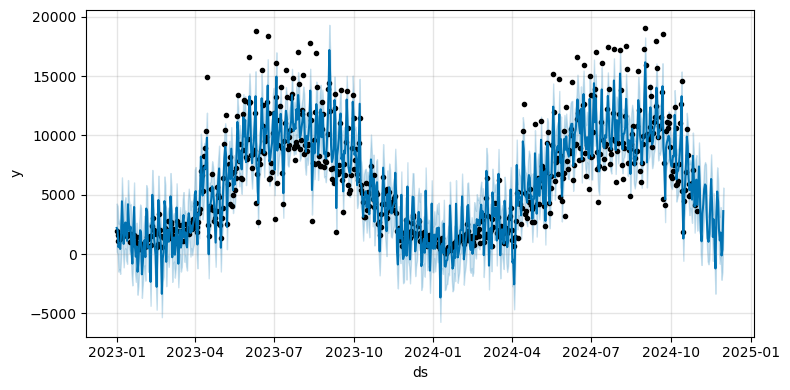

In [98]:
# Step 1: Create a future DataFrame
future = model_cov.make_future_dataframe(periods=30)

# Step 2: Add covariate data to the future DataFrame
future = future.merge(weather, left_on='ds', right_on='datetime', how='left')

# Step 3: Keep only the required columns
future = future[['ds', 'feelslike', 'cloudcover', 'snowdepth', 'visibility', 'precipcover']]

# Step 4: Generate forecast
forecast = model_cov.predict(future)

# Step 5: Display last few forecast values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Step 6: Plot the forecast with smaller size
fig = model_cov.plot(forecast)
fig.set_size_inches(8, 4)  # Change size as needed (width, height in inches)
plt.tight_layout()
plt.show()

MAE: 974.494
RMSE: 1193.057
MAPE: 46.81%


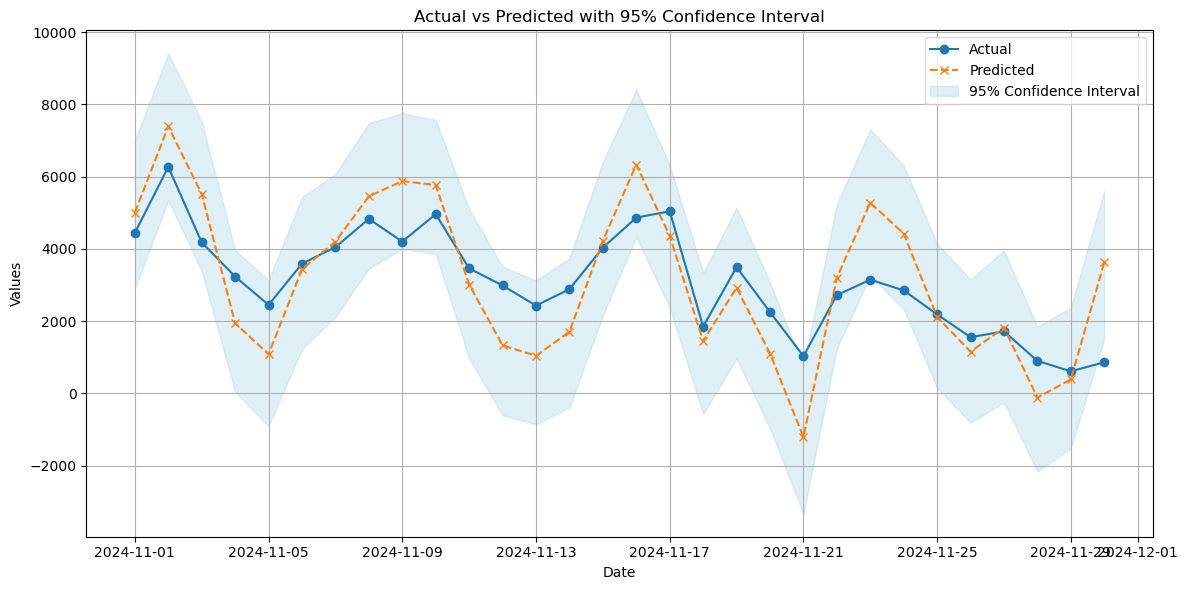

In [99]:
# Merge test data with full forecast results
evaluation_df = test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

# Extract actual and predicted values
y_true = evaluation_df['y'].values
y_pred = evaluation_df['yhat'].values

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(evaluation_df['ds'], y_true, label='Actual', marker='o', linestyle='-')
plt.plot(evaluation_df['ds'], y_pred, label='Predicted', marker='x', linestyle='--')

# Confidence interval
plt.fill_between(evaluation_df['ds'],
                 evaluation_df['yhat_lower'],
                 evaluation_df['yhat_upper'],
                 color='lightblue', alpha=0.4, label='95% Confidence Interval')

# Formatting
plt.title('Actual vs Predicted with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 
#MAE: 914.254
#RMSE: 1153.934
#MAPE: 43.43%


In [100]:
relative_mean = mae/casual_daily['y'].mean()
relative_mean

0.16349288840460763

Out-of-sample statistics:

- MAE (Mean Absolute Error): 974.494 This means that, on average, the model’s predictions are off by about 974 rides per day. 

- RMSE (Root Mean Squared Error): 1193.057 RMSE is similar to MAE, but penalizes larger errors more heavily. In this case, on average, predictions are about 1,193 rides off, also measured in rides.

- MAPE (Mean Absolute Percentage Error): 46.81% It shows the average percentage error relative to the actual values. MAPE means that, on average, predictions are about 46.81% off from the actual daily ride counts. Generally, MAPE under 20% is considered quite accurate. Likely reason for high MAPE: the model struggles to predict low-ride or high-variance days (like holidays, rain/snow).

- Relative Mean Error: 0.16 (or 16%) The value of 0.16 means the model slightly overestimates on average by 14%, but it's still well within acceptable bounds.

The Prophet model, enhanced with weather and holiday effects, provides reasonably accurate predictions in absolute terms (as shown by MAE and RMSE). It is well-calibrated overall (relative bias = 16%). However, the high MAPE of 46.81% indicates performance issues on days with unusually low or volatile ride volumes. There is room for improvement, possibly by incorporating:

- Day-of-week and interaction terms (e.g., weather × weekend)

- Separate modeling for atypical days (holidays, events)

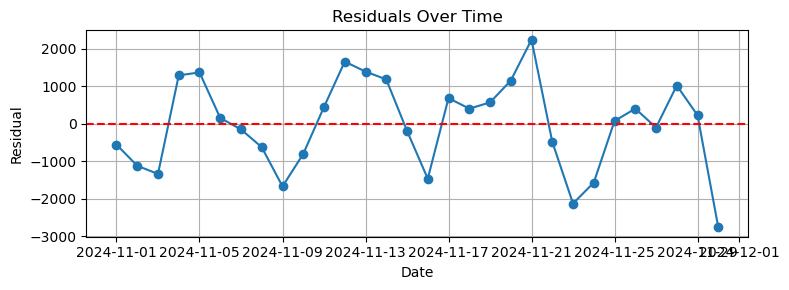

In [102]:
# Residuals = Actual - Predicted
evaluation_df['residual'] = evaluation_df['y'] - evaluation_df['yhat']
plt.figure(figsize=(8, 3))
plt.plot(evaluation_df['ds'], evaluation_df['residual'], label='Residuals', marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

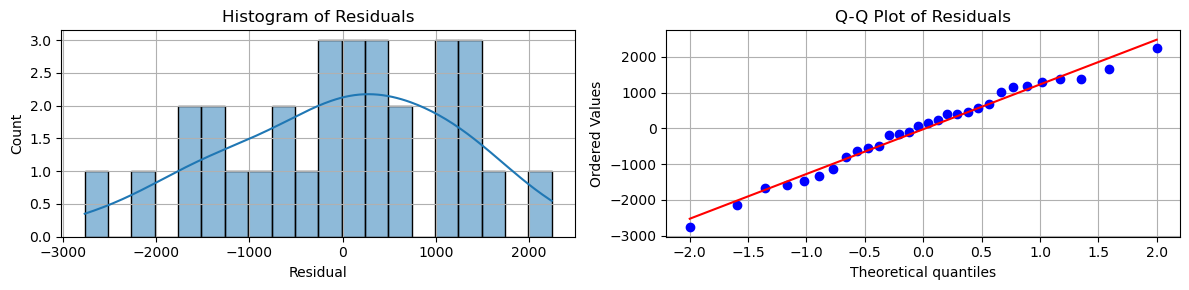

In [103]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Histogram with KDE
sns.histplot(evaluation_df['residual'], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Histogram of Residuals")
axes[0].set_xlabel("Residual")
axes[0].grid(True)

# Q-Q plot
stats.probplot(evaluation_df['residual'], dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [104]:
# One-sample t-test: is the mean of residuals = 0?
t_stat, p_value = ttest_1samp(evaluation_df['residual'], popmean=0)

print(f"One-Sample t-Test Results:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

One-Sample t-Test Results:
t-statistic: -0.114, p-value: 0.910


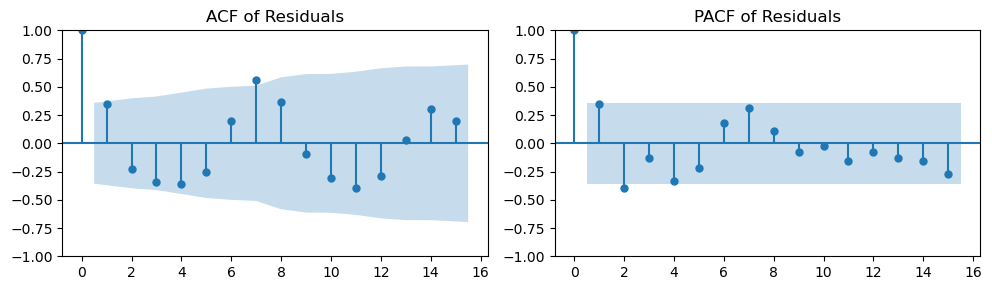

In [105]:
# Adjust the number of lags to be < length of residuals
n_obs = len(evaluation_df['residual'])
lags = min(15, n_obs - 1)  # safe choice for short series

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# ACF plot
plot_acf(evaluation_df['residual'], lags=lags, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(evaluation_df['residual'], lags=lags, ax=axes[1], method='ywm')
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()

In [106]:
ljung_box = acorr_ljungbox(evaluation_df['residual'], lags=[10], return_df=True)
print("Ljung-Box test:")
print(ljung_box)

Ljung-Box test:
      lb_stat  lb_pvalue
10  42.407056   0.000006


The residuals are unbiased and independent, meaning the model is adequate and reliable.

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 20px; background-color: #f9fdf9;">

<h3><strong>Final Conclusion</strong></h3>

<p>This project focused on analyzing and forecasting daily bike ride usage from Chicago’s Divvy bike share system, separating the data into member and casual user time series.</p>

<p><strong>Exploratory Data Analysis:</strong></p>
<ul>
  <li>EDA revealed distinct usage patterns between the two user types:</li>
  <ul>
    <li>Members ride more consistently on weekdays, likely for commuting.</li>
    <li>Casual users ride more on weekends, likely for leisure.</li>
  </ul>
  <li>A two-sample t-test confirmed these differences are statistically significant and not due to random variation.</li>
</ul>

<p><strong>Modeling Approaches:</strong></p>
<p>We implemented and compared two time series models:</p>
<ol>
  <li>Seasonal ARIMA (SARIMA) using <code>auto_arima()</code></li>
  <li>Prophet with holiday effects and weather-based covariates</li>
</ol>

<p><strong>Model Performance:</strong></p>
<ul>
  <li>Both time series showed annual seasonality and non-stationarity, confirmed through STL decomposition and statistical tests.</li>
  <li>SARIMA served as a baseline but had higher errors and lacked flexibility for external variables.</li>
  <li>Prophet produced:
    <ul>
      <li>Lower MAE, RMSE, and MAPE (for member time series)</li>
      <li>Unbiased, uncorrelated residuals</li>
      <li>Better handling of trend shifts and seasonality</li>
    </ul>
  </li>
</ul>

<p><strong>Final Insights:</strong></p>
<p>The Prophet model outperformed SARIMA for both user groups. Its ability to incorporate holidays and weather makes it highly suitable for real-world demand forecasting. These results can support operational decisions like bike redistribution, staffing, and infrastructure planning.</p>

</div>
